# Aragon Conviction Voting Model - Version 1

## Model Overview 

[Conviction Voting](https://medium.com/giveth/conviction-voting-a-novel-continuous-decision-making-alternative-to-governance-aa746cfb9475) is a novel decision making process where votes express their preference for which proposals they would like to see approved in a continuous rather than discrete way. The longer the community keeps a preference on an individual proposal, the “stronger” the proposal conviction becomes. In the conviction voting model, a graph structure is used to record the introduction and removal of participants, candidates, proposals, and their outcomes.

## cadCAD Overview

In the cadCAD simulation [methodology](https://community.cadcad.org/t/differential-specification-syntax-key/31), we operate on four layers: **Policies, Mechanisms, States**, and **Metrics**. Information flows do not have explicit feedback loop unless noted. **Policies** determine the inputs into the system dynamics, and can come from user input, observations from the exogenous environment, or algorithms. **Mechanisms** are functions that take the policy decisions and update the States to reflect the policy level changes. **States** are variables that represent the system quantities at the given point in time, and **Metrics** are computed from state variables to assess the health of the system. Metrics can often be thought of as KPIs, or Key Performance Indicators. 

At a more granular level, to setup a model, there are system conventions and configurations that must be [followed.](https://community.cadcad.org/t/introduction-to-simulation-configurations/34)

The way to think of cadCAD modeling is analogous to machine learning pipelines which normally consist of multiple steps when training and running a deployed model. There is preprocessing, which includes segregating features between continuous and categorical, transforming or imputing data, and then instantiating, training, and running a machine learning model with specified hyperparameters. cadCAD modeling can be thought of in the same way as states, roughly translating into features, are fed into pipelines that have built-in logic to direct traffic between different mechanisms, such as scaling and imputation. Accuracy scores, ROC, etc. are analogous to the metrics that can be configured on a cadCAD model, specifying how well a given model is doing in meeting its objectives. The parameter sweeping capability of cadCAD can be thought of as a grid search, or way to find the optimal hyperparameters for a system by running through alternative scenarios. A/B style testing that cadCAD enables is used in the same way machine learning models are A/B tested, except out of the box, in providing a side by side comparison of muliple different models to compare and contrast performance. Utilizing the field of Systems Identification, dynamical systems models can be used to "online learn" by providing a feedback loop to generative system mechanisms. 


## Differential Specification
![](images/Aragon_v1.png)

## Schema of the states
The model consists of a temporal in memory graph database called *network* containing nodes of type **Participant** and type **Proposal**. Participants will have *holdings* and Proposals will have *funds_required, status*(candidate or active), *conviction*. Edges in the network go from nodes of type Participant to nodes of type Proposal with the edges having the key *type*, of which all will be set to *support*. Edges from participant $i$ to proposal $j$ will have the following additional characteristics:
* Each pairing (i,j) will have *affinity*, which determines how much $i$ likes or dislikes proposal $j$.
* Each participant $i$, assigns its $tokens$ over the edges (i,j) for all $j$ such that the summation of all $j$ such that ```Sum_j = network.edges[(i,j)]['tokens'] = network.nodes[i]['holdings']```
* Each pairing (i,j) will have *conviction* local to that edge whose update at each timestep is computed using the value of *tokens* at that edge.
* Each proposal *j* will have a *conviction* which is equal to the sum of the conviction on its inbound edges: ```network.nodes[j]['conviction'] = Sum_i  network.edges[(i,j)]['conviction']```
* The "trigger function" will check whether each proposal $j$ has met the criteria for passing; if a proposal passes its *status* changes from *candidate* to *active*, and an amount of funds equal to its *funds_required* will be decremented from *funds*.


The other state variable in the model is *funds*, which is a numpy floating point. 

The system consists of 100 time steps without a parameter sweep or monte carlo.


## Partial State Update Blocks

Each partial state update block is kind of a like a phase in a phased based board game. Everyone decides what to do and it reconciles all decisions. One timestep is a full turn, with each block being a phase of a timestep or turn. We will walk through the individaul Partial State update blocks one by one below.

```
{
# system.py: 
'policies': { 
    'random': driving_process
},
'variables': {
    'network': update_network,
    'funds':increment_funds,
}
```

To simulate the arrival of participants and proposal into the system, we have a driving process to represent the arrival of individual agents. For simplification, we are using hyperparameters for supply and sentiment, 1,231,286.81 and 0.6 respectively. We use a random uniform distribution generator, over [0, 1), to calculate the number of new participants. We then use an expoential distribution to calculate the particpant's tokens by using a loc of 0.0 and a scale of expected holdings, which is calcutulaed by .1*supply/number of existing participants. We calcualte the number of new proposals by     
```
proposal_rate = 1/median_affinity * (1+total_funds_requested/funds)
rv2 = np.random.rand()
new_proposal = bool(rv2<1/proposal_rate)
```
The network state variable is updated to include the new participants and proposals, while the funds state variable is updated for the increase in system funds. 
[To see the partial state update code, click here](model/model/system.py)

```
{
  # participants.py   
  'policies': {
      'completion': check_progress 
    },
    'variables': { 
        'network': complete_proposal
    }
},
```

In the next phase of the turn, [to see the logic code, click here](model/model/participants.py), the *check_progress* behavior checks for the completion of previously funded proposals. The code calculates the completion and failure rates as follows:

```
likelihood = 1.0/(base_completion_rate+np.log(grant_size))

failure_rate = 1.0/(base_failure_rate+np.log(grant_size))
if np.random.rand() < likelihood:
    completed.append(j)
elif np.random.rand() < failure_rate:
    failed.append(j)
```
With the base_completion_rate being 100 and the base_failure_rate as 200. 

The mechanism then updates the respective *network* nodes. 

```
{
 # proposals.py
  'policies': {
      'release': trigger_function 
    },
    'variables': { 
        'funds': decrement_funds, 
        'network': update_proposals 
    }
},
 ```
 
The [trigger release function](model/model/proposals.py) checks to see if each proposal passes or not. If a proposal passes, funds are decremented by the amount of the proposal, while the proposal's status is changed in the network object.

```
{ 
    # participants.py
    'policies': { 
        'participants_act': participants_decisions
    },
    'variables': {
        'network': update_tokens 
    }
}
```

The Participants decide based on their affinity if which proposals they would like to support,[to see the logic code, click here](model/model/participants.py). Proposals that participants have high affinity for receive more support and pledged tokens than proposals with lower affinity and sentiment. We then update everyone's holdings and their conviction for each proposal.


## Model next steps

The the model described above is a minimalist model, first iteration model that covers the core mechanisms of the Aragon Conviction Voting model. Below are next additional dynamics we can attend to enrich the model, and provide workstreams for subsequent iterations of this lab notebook.
* Sentiment
* Mixing of token holdings among participants
* Departure of participants
* Participants influencing each others opinions
* Proposals which are good or no good together
* Multiple proposal stages such as killed, failed and completed
* Affects of outcomes on sentiment

# Simulation

## Configuration
let's factor out into its own notebook where we review the config object and its partial state update blocks, with a slightly deeper dive on the trigger function. 

In [1]:
from model import economyconfig

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# pull out configurations to illustrate
sim_config,genesis_states,seeds,partial_state_update_blocks = economyconfig.get_configs()

In [3]:
sim_config

{'N': 1, 'T': range(0, 100), 'M': [{}], 'simulation_id': 0, 'run_id': 0}

In [4]:
partial_state_update_blocks

[{'policies': {'random': <function model.model.system.driving_process(params, step, sL, s)>},
  'variables': {'network': <function model.model.system.update_network(params, step, sL, s, _input)>,
   'funds': <function model.model.system.increment_funds(params, step, sL, s, _input)>}},
 {'policies': {'completion': <function model.model.participants.check_progress(params, step, sL, s)>},
  'variables': {'network': <function model.model.participants.complete_proposal(params, step, sL, s, _input)>}},
 {'policies': {'release': <function model.model.proposals.trigger_function(params, step, sL, s)>},
  'variables': {'funds': <function model.model.proposals.decrement_funds(params, step, sL, s, _input)>,
   'network': <function model.model.proposals.update_proposals(params, step, sL, s, _input)>}},
 {'policies': {'participants_act': <function model.model.participants.participants_decisions(params, step, sL, s)>},
  'variables': {'network': <function model.model.participants.update_tokens(params

## Initialization
To create the genesis_states, we create our in-memory graph database within networkx. 

In [5]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from model.model.conviction_helper_functions import * 

# Parameters
n= 60 #initial participants
m= 3 #initial proposals

initial_sentiment = .6

initial_funds = 40781.42

def initialize_network(n,m, inital_funds, expected_supply = 10**6):
    '''
    Definition:
    Function to initialize network x object
    '''
    # initilize network x graph
    network = nx.DiGraph()
    # create participant nodes with type and token holding
    for i in range(n):
        network.add_node(i)
        network.nodes[i]['type']= "participant"
        
        h_rv = expon.rvs(loc=0.0, scale= expected_supply/n)
        network.nodes[i]['holdings'] = h_rv
        
    
    participants = get_nodes_by_type(network, 'participant')
    initial_supply = np.sum([ network.nodes[i]['holdings'] for i in participants])
       
    
    # Generate initial proposals
    for ind in range(m):
        j = n+ind
        network.add_node(j)
        network.nodes[j]['type']="proposal"
        network.nodes[j]['conviction'] = 0
        network.nodes[j]['status'] = 'candidate'
        network.nodes[j]['age'] = 0
        
        r_rv = gamma.rvs(3,loc=0.001, scale=10000)
        network.nodes[j]['funds_requested'] = r_rv
        
        network.nodes[j]['trigger']= trigger_threshold(r_rv, initial_funds, initial_supply)
        
        for i in range(n):
            network.add_edge(i, j)
            
            rv = np.random.rand()
            a_rv = 1-4*(1-rv)*rv #polarized distribution
            network.edges[(i, j)]['affinity'] = a_rv
            network.edges[(i, j)]['tokens'] = 0
            network.edges[(i, j)]['conviction'] = 0
            network.edges[(i, j)]['type'] = 'support'
            
        proposals = get_nodes_by_type(network, 'proposal')
        total_requested = np.sum([ network.nodes[i]['funds_requested'] for i in proposals])
        
        
    return network, initial_funds

# run the initialize_network function to create the initial states of the simulation
network, initial_funds = initialize_network(n,m,initial_funds)


# Create initial states
genesis_states = { 
                'network':network,
                'funds':initial_funds

}

In [6]:
genesis_states

{'network': <networkx.classes.digraph.DiGraph at 0x7fba43812850>,
 'funds': 40781.42}

In [7]:
# To explore our model prior to the simulation, we extract key components from our networkX object into lists.
proposals = get_nodes_by_type(network, 'proposal')
participants = get_nodes_by_type(network, 'participant')
supporters = get_edges_by_type(network, 'support')

#### Exploring the State Data Structure

A graph is a type of temporal data structure that evolves over time. A graph $\mathcal{G}(\mathcal{V},\mathcal{E})$ consists of vertices or nodes, $\mathcal{V} = \{1...\mathcal{V}\}$ and is connected by edges  $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$.

See *Schema of the states* above for more details


Let's explore!

In [8]:
#sample a participant
network.nodes[participants[0]]

{'type': 'participant', 'holdings': 13405.936600677995}

Text(0.5, 1.0, 'Histogram of Participants Token Holdings')

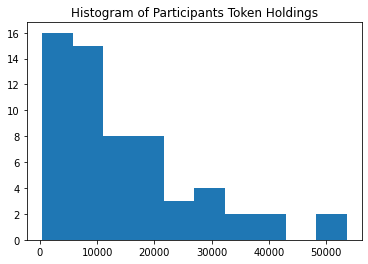

In [9]:
# Let's look at the distribution of participant holdings at the start of the sim
plt.hist([ network.nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')

In [10]:
#lets look at proposals
network.nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 28688.73180684115,
 'trigger': inf}

Proposals initially start without any conviction, and with the status of a candidate. If the proposal's amount of  conviction is greater than it's trigger, then the proposal moves to active and it's funds requested are granted. 

All initial proposal start with 0 conviction and state 'candidate'we can simply examine the amounts of funds requested

Text(0.5, 0, 'Proposals')

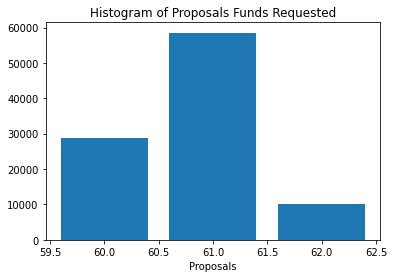

In [11]:
plt.bar( proposals, [ network.nodes[i]['funds_requested'] for i in proposals])
plt.title('Histogram of Proposals Funds Requested')
plt.xlabel('Proposals')

Conviction is a concept that arises in the edges between participants and proposals in the initial conditions there are no votes yet so we can look at that later however, the voting choices are driven by underlying affinities which we can see now.

Text(0.5, 137.58, 'participant_id')

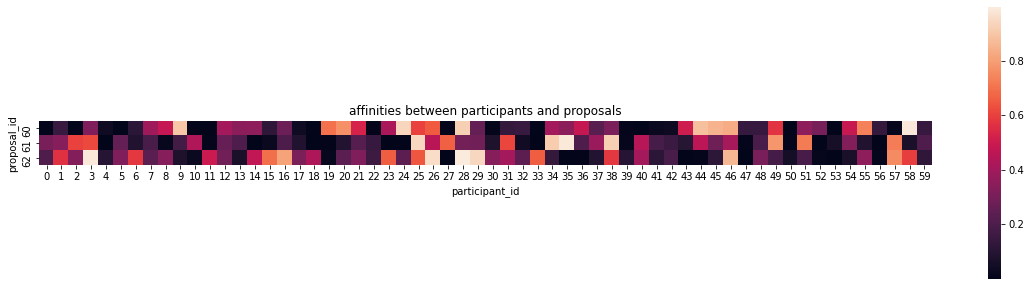

In [12]:
affinities = np.empty((n,m))
for i_ind in range(n):
    for j_ind in range(m):
        i = participants[i_ind]
        j = proposals[j_ind]
        affinities[i_ind][j_ind] = network.edges[(i,j)]['affinity']

dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=participants,
            yticklabels=proposals,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

## Run simulation

Now we will create the final system configuration, append the genesis states we created, and run our simulation.

In [13]:
from cadCAD.configuration import append_configs

# Create configuration
append_configs(
    sim_configs=sim_config,
    initial_state=genesis_states,
    seeds=seeds,
    partial_state_update_blocks=partial_state_update_blocks
)

In [14]:
import numpy as np
import pandas as pd
from model.model.conviction_helper_functions import *
from model import run
from cadCAD import configs
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

# Pass in configuration to run
df = run.run(configs)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 1, 1, 2)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 40.68s


After the simulation has run successfully, we perform some postprocessing to extract node and edge values from the network object and add as columns to the pandas dataframe. For the rdf, we take only the values at the last substep of each timestep in the simulation.

In [15]:
df,rdf = run.postprocessing(df)

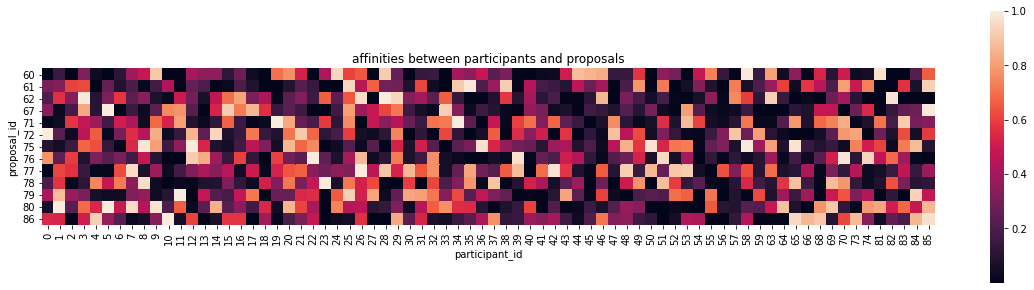

In [16]:
affinities_plot(df)

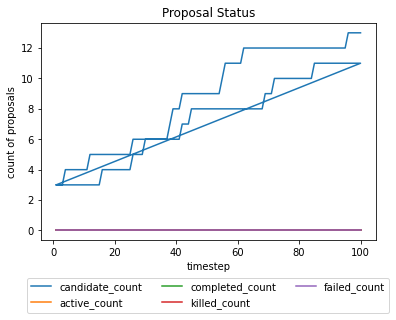

In [17]:
rdf.plot(x='timestep',y=['candidate_count','active_count','completed_count', 'killed_count', 'failed_count'])
plt.title('Proposal Status')
plt.ylabel('count of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

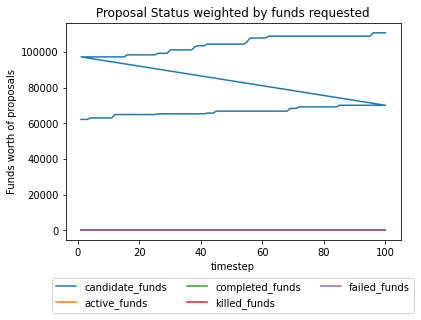

In [18]:
rdf.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds', 'killed_funds', 'failed_funds'])
plt.title('Proposal Status weighted by funds requested')
plt.ylabel('Funds worth of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

In [19]:
nets = rdf.network.values

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:569: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  

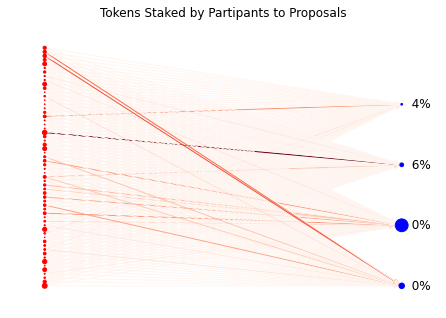

In [20]:
K = 3
snap_plot(nets[K:K+1], size_scale = 1/300)

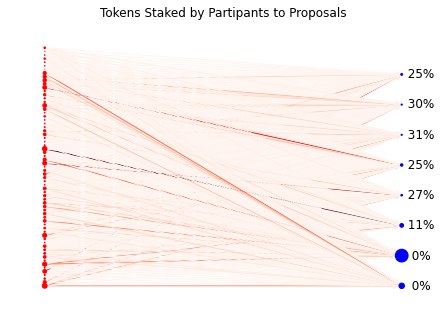

In [21]:
K = 56
snap_plot(nets[K:K+1], size_scale = 1/300)

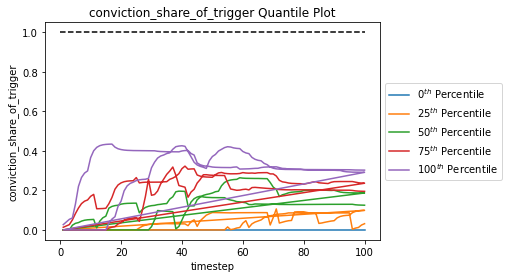

In [22]:
quantile_plot('timestep','conviction_share_of_trigger', rdf, .25)
plt.hlines(1,0,df.timestep.values[-1], linestyle='--')

## Conclusion

We have created a simplified conviction voting model that illustrates the state objects, and provides descriptions of how the model fits together. In subsequent notebooks, we will expand the model to introduce additional complexity to more fit real world implementations. 